In [28]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
from math import *
import pandas as pd
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import interpolate
from random import *
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, ICRS, Galactic
import astropy.units as units
import galpy.util.bovy_coords as gub
import os
sys.path.append("../TOOLBOX/")
from growing_region import *
from tool import *
from tool_norm import *

U_sun, V_sun, W_sun = 11.1, 12.24, 7.25
X_sun = 8.3
V_LSR = 232

sns.set_style("whitegrid")
matplotlib.rcParams.update({'font.size': 15})


In [106]:
import tensorflow as tf


/Users/yuan/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)



In [108]:
print(tf.__version__)

1.15.0


In [64]:
data_path = "../DATA/"
res_path = "../RES/"
fig_path = "../FIG/"

# Load Data

In [81]:
t=Table.read(res_path+"comaber_coma_85target_pm1_dn_xyz.fits")
mock = Table.read(res_path+"comaber_mock_xyz.fits")


# Load Map

In [82]:
u_mtx= np.load(res_path+"u_ComaBer_85target_pm1_dn.npy")
w = np.load(res_path+"w_ComaBer_85target_pm1_dn.npy")
d_vw = np.load(res_path+"d_vw_ComaBer_85target_pm1_dn.npy")

map_som = np.load(res_path+"map_ComaBer_85target_pm1_dn.npy")
m = u_mtx.shape[0] + 1
n = u_mtx.shape[1] + 1
print (map_som.shape)
xm, ym = np.mgrid[slice(0, m, 1),slice(0, n, 1)]
id_star = map_som[:, 0] * m + map_som[:, 1]


(5494, 2)


In [88]:
d_vw_mock = np.load(res_path+"d_vw_mock_ComaBer_85target_pm1_dn.npy")

map_mock = np.load(res_path+"map_mock_ComaBer_85target_pm1_dn.npy")

id_mock = map_mock[:, 0] * m + map_mock[:, 1]


# SOM

In [33]:
#u-matrix gives diff b/w weight vectors of neighboring neurons

u = u_mtx.flatten()

logu_mtx = np.log10(u_mtx)

logu = np.log10(u)

print (logu)

logu_low = np.percentile(logu, 2.5)-0.5
logu_upp = np.percentile(logu, 97.5)+0.5

print (logu_low)

[-2.2647507 -1.9948345 -2.0930479 ... -2.0563166 -2.1886816 -2.3940918]
-3.398064136505127


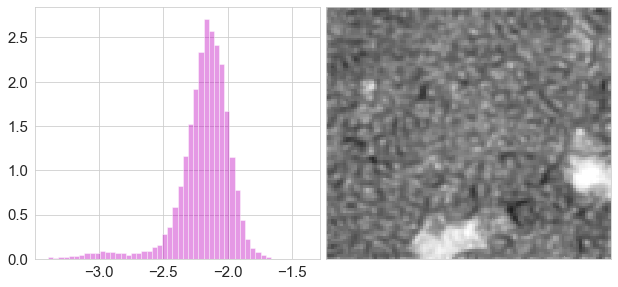

In [34]:
fig = figure(figsize = (10,5))
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.1, right= 0.9, bottom = 0.2, top = 0.9, wspace=0.02, hspace = 0.)
ax1 = subplot(gs[0, 0])
ax2 = subplot(gs[0, 1])


sns.distplot(logu,bins = 50, hist_kws={"range": [logu_low, logu_upp]},
             hist=True, kde=False, norm_hist=True, color="m", ax=ax1)
ax2.pcolormesh(xm, ym, logu_mtx, cmap='Greys',vmin=logu_low,vmax=logu_upp)

for ax in [ax2]:
    ax.set_xlim(0, m-1)
    ax.set_ylim(0, n-1)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  



# Group Identification

## Determine $u_{thr}$ from distribution of u

In [38]:
hist, bin_edges = np.histogram(logu0,bins=55,range=(-4,-1.5))
bin_center = 0.5*(bin_edges[:-1] + bin_edges[1:])
ind_peak = np.argmax(hist)

delta = np.percentile(logu0,100-0.15)-bin_center[ind_peak]
logu_thr = bin_center[ind_peak]-delta
print (logu_thr)

-2.6013173103332496


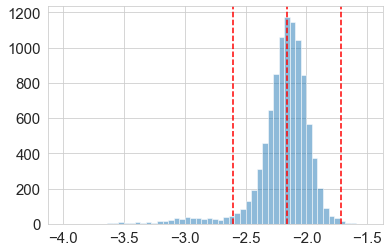

In [39]:
figure()

plt.hist(logu0,bins=55,range=(-4,-1.5),alpha=0.5);

axvline(bin_center[ind_peak],ls="dashed",c="r")
axvline(logu_thr,ls="dashed",c="r")
axvline(np.percentile(logu0,99.85),ls="dashed",c="r")



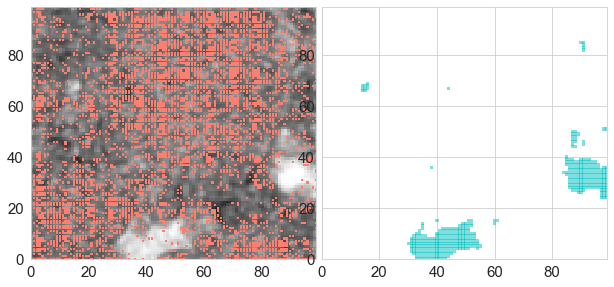

In [90]:
cand = GR(u_mtx, 10**logu_thr)

id_cand = cand.get_id_grp()

xc = np.int64(id_cand / m)
yc = id_cand - xc * m
fig = figure(figsize = (10,5))
gs = gridspec.GridSpec(1,2)
gs.update(left=0.1, right= 0.9, bottom = 0.2, top = 0.9, wspace=0.02, hspace = 0.)
ax1 = subplot(gs[0, 0])
ax2 = subplot(gs[0, 1])

for ax in [ax1,ax2]:

    ax.set_xlim(0,m-1)
    ax.set_ylim(0,n-1)
    
ax1.pcolormesh(xm, ym, logu_mtx, cmap='Greys',vmin=logu_low,vmax=logu_upp)
ax1.scatter(map_mock[:,0], map_mock[:,1], marker="s",edgecolor = "None", facecolor="salmon", s = 5, lw =1)

ax2.scatter(xc, yc, facecolor = "c", edgecolor = "None", s  =  10, marker = "s", alpha = 0.5) 



## Identification Groups -- $u_{thr}$ 

In [74]:
gcolor=["red","blue","salmon","mediumseagreen","crimson","maroon","mediumseagreen", "navy"]
gmarker = ["o", "d", "^", "v", ">","<","p","s","D"]
sigma2 = 0.975
num_min = 5
cr_max = 0.2

202
0.06788191298331163
172
0.07529279366430626


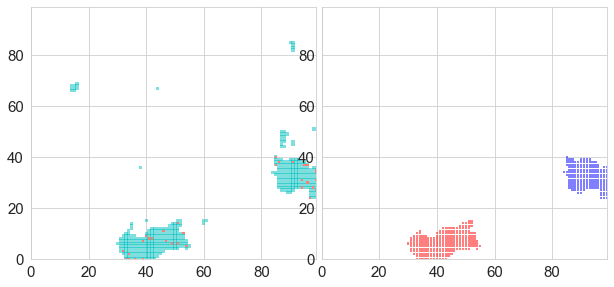

In [99]:
cand_som1 = []

seed_cand  = np.array([[40, 10], [90, 35]])

id_seed_cand = seed_cand[:,0] * m + seed_cand[:,1]


fig = figure(figsize = (10,5))
gs = gridspec.GridSpec(1,2)
gs.update(left=0.1, right= 0.9, bottom = 0.2, top = 0.9, wspace=0.02, hspace = 0.)
ax1 = subplot(gs[0, 0])
ax2 = subplot(gs[0, 1])

for ax in [ax1,ax2]:

    ax.set_xlim(0,m-1)
    ax.set_ylim(0,n-1)
  
ax1.scatter(xc, yc, facecolor = "c", edgecolor = "None", s  =  10, marker = "s", alpha = 0.5)


            
for i in range(len(id_seed_cand)):

    new_cand = cand.get_group(id_seed_cand[i])
    x = np.int64(new_cand / m)
    y = new_cand - x * m
    
    
    ind = np.in1d(id_star, new_cand)
    print (len(id_star[ind]))
    
    cand_som1.append(new_cand)
    
    ind_m = np.in1d(id_mock,cand_som1[i])
    num_mock = len(id_mock[ind_m])
    p_mock = num_mock/len(id_mock)
    ind = np.in1d(id_star, cand_som1[i])
    p = len(id_star[ind])/len(id_star)
    r = p_mock/p
    print (r)
    ax1.scatter(map_mock[ind_m,0], map_mock[ind_m,1], marker="s",edgecolor = "None", facecolor="salmon", s = 5, lw =1)

    ax2.scatter(x, y, marker="s",edgecolor = "None", facecolor=gcolor[i], s = 5, alpha=0.5)
        
   


# Plots

202
172


Text(0, 0.5, 'DEC')

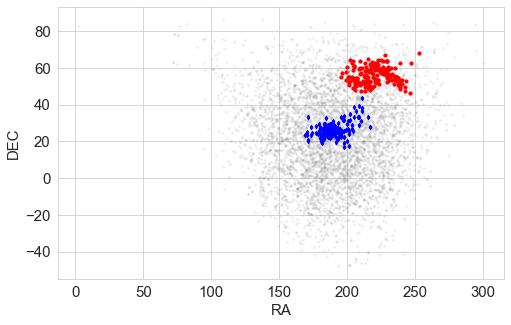

In [100]:
figure(figsize=(8,5))
scatter(t["ra"],t["dec"],color="gray",s=3,alpha=0.1)

for i in range(len(cand_som1)):
    
    ind = np.in1d(id_star,cand_som1[i])
    
   
    scatter(t["ra"][ind],t["dec"][ind],color=gcolor[i],marker=gmarker[i],s=10)
    print (len(id_star[ind]))
    
xlabel("RA")    
ylabel("DEC")    

#xlim(360,0)
#ylim(-80,80)

202
172


Text(0, 0.5, 'PMDEC')

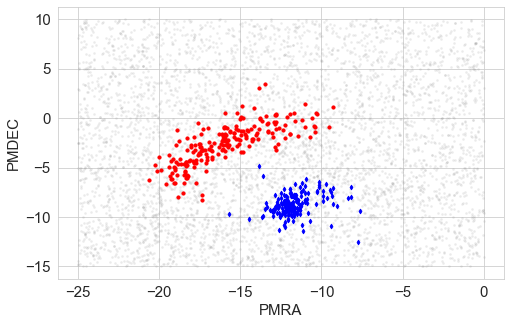

In [101]:
figure(figsize=(8,5))
scatter(t["pmra"],t["pmdec"],color="gray",s=3,alpha=0.1)

for i in range(len(cand_som1)):
    
    ind = np.in1d(id_star,cand_som1[i])
    
   
    scatter(t["pmra"][ind],t["pmdec"][ind],color=gcolor[i],marker=gmarker[i],s=10)
    print (len(id_star[ind]))
    
xlabel("PMRA")    
ylabel("PMDEC")    

#xlim(360,0)
#ylim(-80,80)

Text(0, 0.5, '$z\\/(pc)$')

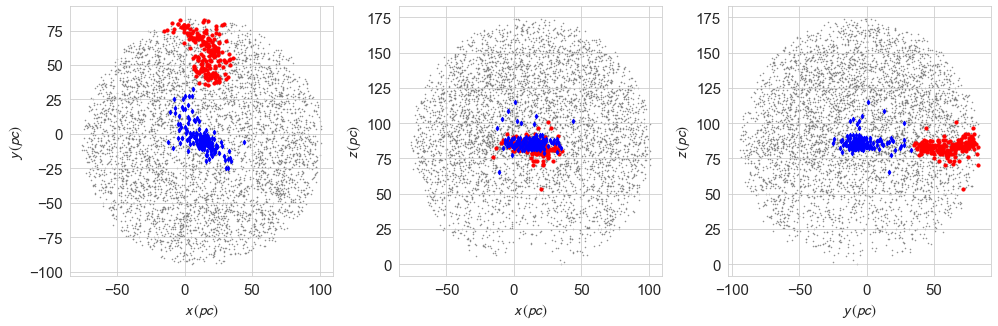

In [102]:
fig = figure(figsize = (16,5))
gs = gridspec.GridSpec(1, 3)
gs.update(left=0.1, right= 0.9, bottom = 0.15, top = 0.9, wspace=0.25, hspace = 0.)
ax1 = subplot(gs[0, 0])
ax2 = subplot(gs[0, 1])
ax3 = subplot(gs[0, 2])
ax1.plot(t["x"], t["y"], ".", ms=1, color="gray", zorder=0)
ax2.plot(t["x"], t["z"], ".", ms=1, color="gray", zorder=0)
ax3.plot(t["y"], t["z"], ".", ms=1, color="gray", zorder=0)


for i in range(len(cand_som1)):
    
    ind = np.in1d(id_star,cand_som1[i])
    
   
    ax1.scatter(t["x"][ind], t["y"][ind],color=gcolor[i],marker=gmarker[i],s=10)
    ax2.scatter(t["x"][ind], t["z"][ind],color=gcolor[i],marker=gmarker[i],s=10)
    ax3.scatter(t["y"][ind], t["z"][ind],color=gcolor[i],marker=gmarker[i],s=10)
    
    
ax1.set_xlabel(r"$x\/(pc)$")
ax1.set_ylabel(r"$y\/(pc)$")
ax2.set_xlabel(r"$x\/(pc)$")
ax2.set_ylabel(r"$z\/(pc)$")
ax3.set_xlabel(r"$y\/(pc)$")
ax3.set_ylabel(r"$z\/(pc)$")

# Fig 1 in Tang et al. 2019

In [103]:
gcolor=["b","r"]

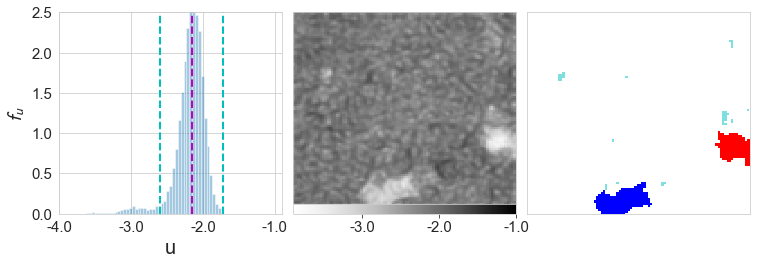

In [104]:
fig = figure(figsize = (12,4))
gs = gridspec.GridSpec(1, 3)
gs.update(left=0.1, right= 0.9, bottom = 0.2, top = 0.9, wspace=0.05, hspace = 0.)
ax1 = subplot(gs[0, 0])
ax2 = subplot(gs[0, 1])
ax3 = subplot(gs[0, 2])



divider = make_axes_locatable(ax2)

cax = divider.new_vertical(size="5%", pad=0.0,pack_start=True)
fig.add_axes(cax)



im=ax2.pcolormesh(xm, ym, logu_mtx, cmap='Greys', vmin=-3.9, vmax=-1.)

cb=colorbar(im,cax=cax,orientation="horizontal",format='%.1f')





sns.distplot(logu0,bins = 50, hist_kws={"range": [-3.75,-1.75]},
             hist=True, kde=False, norm_hist=True, ax= ax1)



ax1.axvline(bin_center[ind_peak],ls="dashed",c="m",lw=2)
ax1.axvline(logu_thr,ls="dashed",c="c",lw=2)
ax1.axvline(np.percentile(logu0,99.85),ls="dashed",c="c",lw=2)

ax1.grid(True)

ax1.set_xlabel("u",fontsize=20)     
ax1.set_ylabel(r"$f_{u}$",fontsize=20)     


ax1.set_xlim(-4,-0.9)
ax1.set_ylim(0, 2.5)

ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


ax3.scatter(xg_thr, yg_thr, marker="s",edgecolor = "None", facecolor="c", s = 5,alpha=0.5)
for i in range(len(cand_som1)):
    
    x = np.int64(cand_som1[i] / m)
    y = cand_som1[i] - x * m
    
    ax3.scatter(x, y, marker="s",edgecolor = "None", facecolor=gcolor[i], s = 5,alpha=1)



for ax in [ax2, ax3]:
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    
    ax.grid(False)

    ax.set_xlim(0, m-1)
    ax.set_ylim(0, n-1)


savefig(fig_path+"som.png")

# Save Data

In [68]:
ind0 = np.in1d(id_star,cand_som1[0])
ind1 = np.in1d(id_star,cand_som1[1])
t[ind0].write(res_path+"ComaBer_original_xyzpm_dn_n.fits",overwrite=True)
t[ind1].write(res_path+"ComaBer_original_xyzpm_dn_c.fits",overwrite=True)
